In [241]:
# FIRST STEP
# interact with the operating system 
import os
from pathlib import Path
import git
import glob
import csv
# data structuration and calculations
import pandas as pd  # to create data frames
import numpy as np   # most important numerical calculations
from scipy.stats import pearsonr
import pingouin as pg
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
import statsmodels.formula.api as smf
# needed to extract the run number out of the parentesis of the string in the SPM.mat file
import re
# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt

from nilearn.image import load_img, new_img_like
from nilearn import plotting
from nilearn import surface
import nibabel as nib

/gpfs01/bartels/user/vplikat/anaconda3/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
################################################
# VARIABLES FOR PATH SELECTION AND DATA ACCESS #
################################################
HOME            = str(Path.home())
# DATA
STIM_DIR = os.path.join(HOME,'Documents/Magic_fMRI/Stimuli')
PROJ_DIR        = os.path.join(HOME, 'Documents/Magic_fMRI/DATA/MRI')
RAW_DIR         = os.path.join(PROJ_DIR, 'rawdata')
DERIVATIVES_DIR = os.path.join(PROJ_DIR, 'derivatives')
DATA_DIR = os.path.join(DERIVATIVES_DIR, 'univariate-ROI', 'SpecialMoment', 'MagicEffects')

In [10]:
# define ROIs
ROIS = [
        'V1', 'V2', 'V3', 'hV4',  # Benson
        'V3A', 'V3B', 'LO', 'VO', 'IPS',  # Benson
        'PH',  # Glasser 12d,13d (inferior temporal gyrus, temporo-occipital division LR)
        'IPC',  # Glasser 4d (anterior supramarginal gyrus L)
        'IFJ', '44', '6r',  # Glasser d15, d16 (inferior frontal gyrus LR)
        'BA6', 'FEF',  # Glasser 9d, 10d, 1p (superior/middle frontal gyrus LR)
        'pACC', 'mACC', 'aACC', '8BM',  # Glasser 5d,6d,4p (ACC LR)
        'AI', 'AVI',  # Glasser 7d,8d (anterior insula LR)
        'IFS', '45', 'BA46',  # Glasser 3d, 3p (inferior frontal gyrus, pars triangularis L)
        'BA8', 'BA9'  # Glasser 2p (middle frontal gyrus/DLPFC L)
      ]
NETWORKS = ['DMN', 'DAN', 'VAN', 'visual']
EFFECTS = ['Appear', 'Change', 'Vanish']
PRE_POST = ['pre', 'post']

In [43]:
# plotting parameter
# font settings - recommendation from here: https://towardsdatascience.com/making-publication-quality-figures-in-python-part-i-fig-and-axes-d86c3903ad9b
mpl.rcParams['pdf.fonttype']=42
mpl.rcParams['ps.fonttype']=42
mpl.rcParams['font.family']='Arial'

# width and hight is given in inch 
# -> APA says a one column figure should be 2-3.25 inches and a two column figure should be 4.25-6.875 inches
one_col_width = 3.25
two_col_width = 6.875
# linewidth and markersize
linewidth = 2
markersize = 5
# fontsizes -> must be 8-14
titlefont = 14
labelfont = 12
legend_titlefont = 10
legendfont = 8
tickfont = 8

In [30]:
pre_post_maineffect = pd.read_csv(os.path.join(DATA_DIR,'pre_post_maineffect.csv'))
pre_post_maineffect.to_excel('univar_roi_prepost.xlsx')

In [23]:
effect_maineffect = pd.read_csv(os.path.join(DATA_DIR,'effect_maineffect.csv'))
effect_maineffect.to_excel('univar_roi_mageffect.xlsx')

In [34]:
interaction_effect = pd.read_csv(os.path.join(DATA_DIR,'interaction.csv'))
interaction_effect.to_excel('univar_roi_interaction.xlsx')

In [39]:
eff_posthoc = glob.glob(os.path.join(DATA_DIR,'*effect_post_hoc.csv'))
eff_posthoc.sort()
for eff in eff_posthoc:
    print('Inspecting {}'.format(os.path.basename(eff)))
    res = pd.read_csv(eff)
    #print(res)
    res.to_excel(os.path.basename(eff)[:-4]+'.xlsx')

Inspecting LO_effect_post_hoc.csv
Inspecting V1_effect_post_hoc.csv
Inspecting V2_effect_post_hoc.csv
Inspecting V3_effect_post_hoc.csv
Inspecting VAN_effect_post_hoc.csv
Inspecting VO_effect_post_hoc.csv
Inspecting aINSULA_effect_post_hoc.csv
Inspecting hV4_effect_post_hoc.csv


In [40]:
param_interactions = glob.glob(os.path.join(DATA_DIR,'*interaction_post_hoc.csv'))
for interaction in param_interactions:
    print('Inspecting {}'.format(os.path.basename(interaction)))
    res = pd.read_csv(interaction)
    #print(res)
    res.to_excel(os.path.basename(interaction)[:-4]+'.xlsx')

Inspecting PCC_interaction_post_hoc.csv
Inspecting IFG_interaction_post_hoc.csv


In [41]:
non_param_interactions = glob.glob(os.path.join(DATA_DIR,'*wilcox_interaction.csv'))
for interaction in non_param_interactions:
    print('Inspecting {}'.format(os.path.basename(interaction)))
    res = pd.read_csv(interaction)
    #print(res)
    res.to_excel(os.path.basename(interaction)[:-4]+'.xlsx')

Inspecting V3A_wilcox_interaction.csv
Inspecting IFJ_wilcox_interaction.csv
Inspecting PHT_wilcox_interaction.csv
Inspecting DMN_wilcox_interaction.csv
Inspecting IPS_wilcox_interaction.csv
Inspecting PF_wilcox_interaction.csv
Inspecting visual_wilcox_interaction.csv
Inspecting V3B_wilcox_interaction.csv
Inspecting DAN_wilcox_interaction.csv


In [15]:
# multidimensional scaling of univariate ROI results
# the dimensions are effect x pre-post (=6 dimensions)

#------------------------------------------------------------#
# read in data frame containing ROI values for each subject and condition
data_frame = pd.read_csv(os.path.join(DATA_DIR,'prepared_dataframe.csv'))

avg_dict = {}
for roi in ROIS:
    avg_dict[roi]=[]
    for eff in EFFECTS:
        for pp in PRE_POST:
            x = data_frame[roi][(data_frame.pre_post==pp)&(data_frame.Effect==eff)].mean()
            avg_dict[roi].append(x)
            
avg_df = pd.DataFrame(data=avg_dict,columns=avg_dict.keys())

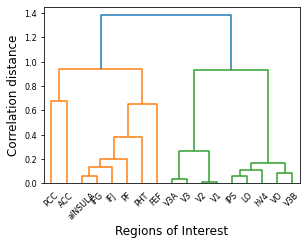

In [54]:
linked = linkage(y=avg_df.T, method='average', metric='correlation')
labelList = ROIS

fig = plt.figure(figsize=(two_col_width*2/3, one_col_width))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.xlabel('Regions of Interest',fontsize=labelfont)
plt.ylabel('Correlation distance',fontsize=labelfont)
plt.xticks(rotation=45, fontsize=tickfont)
plt.yticks(fontsize=tickfont)
fig.savefig('dendrogram.eps',format = 'eps',bbox_inches='tight')

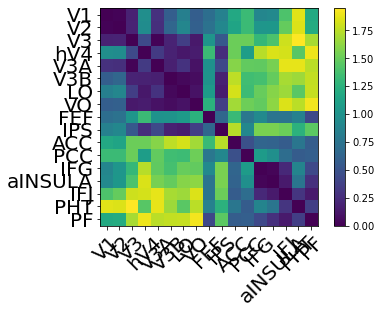

In [6]:
corr_dists = []
for name1, values1 in avg_df.iteritems():
    for name2, values2 in avg_df.iteritems():
        corr_dists.append(pearsonr(values1,values2)[0])
        
corr_dist_matrix = 1-np.array(corr_dists).reshape(len(ROIS),len(ROIS))

fig = plt.figure()
plt.imshow(corr_dist_matrix)
plt.colorbar()
plt.xticks(range(len(ROIS)),ROIS, fontsize=20, rotation=45)
plt.yticks(range(len(ROIS)),ROIS, fontsize=20);

## timeevolution of significant clusters in wholebrain analysis

In [275]:
# get the data and other important namings
DATA_DIR = os.path.join(DERIVATIVES_DIR, 'snpm13', 'snpm13-sla', 'WholeBrain', 
                        'VideoTypes', '6mm-smoothed-mnispace', 'SpecialMoment')
# First Magic pre>post
currentcontrast = 'MagPre-ConPre vs MagPost-ConPost'
# get all cluster dataframes
AIC_csv = glob.glob(os.path.join(DATA_DIR, currentcontrast, 'cluster_AICs.csv'))
AIC_df = pd.read_csv(AIC_csv[0], index_col=0)

# READ IN THE RESULT IMAGE AND USE THE CLUSTER LABEL IMAGE AS MASK
img_path = os.path.join(DATA_DIR,currentcontrast,'uncorrKclusterThrIMG.nii')
current_img = load_img(img_path)
img_data = current_img.get_fdata()

label_path = os.path.join(DATA_DIR,currentcontrast,'clusters.nii')
current_labels = load_img(label_path)
label_data = current_labels.get_fdata()

clusters_of_interest = (np.min([AIC_df.runs_in_block, AIC_df.runs], axis=0) - AIC_df.pre_post)>4
clusters_of_interest = np.array(clusters_of_interest[clusters_of_interest].index)

new_img_data = np.isin(label_data, clusters_of_interest)
results = new_img_like(ref_niimg=current_img, data=new_img_data)
nib.save(results, os.path.join(DATA_DIR,currentcontrast,'pre_postClusters.nii'))

In [276]:
AIC_df

,pre_post,runs_in_block,runs,cluster
0,832.767947,834.585590,839.484164,1
1,1070.795134,1069.969651,1069.930424,2
2,1214.803953,1218.851630,1225.974963,3
3,1418.944920,1440.161270,1433.891802,4
4,NaN,NaN,NaN,5
5,NaN,NaN,NaN,6
6,NaN,NaN,NaN,8
7,976.044838,978.926585,985.149438,9
8,1279.607789,1281.333467,1284.007352,10
9,1522.336195,1521.958670,1526.732472,11


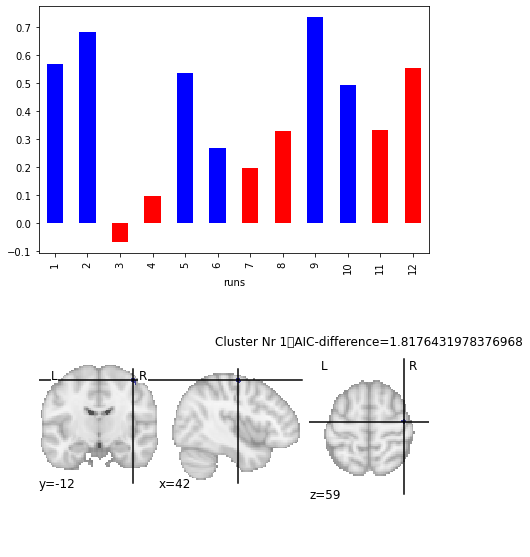

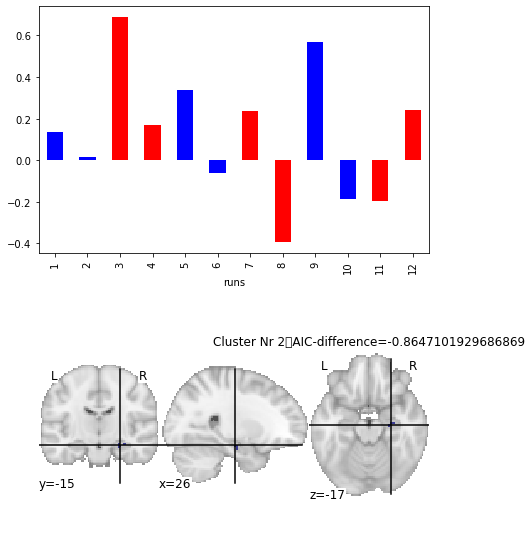

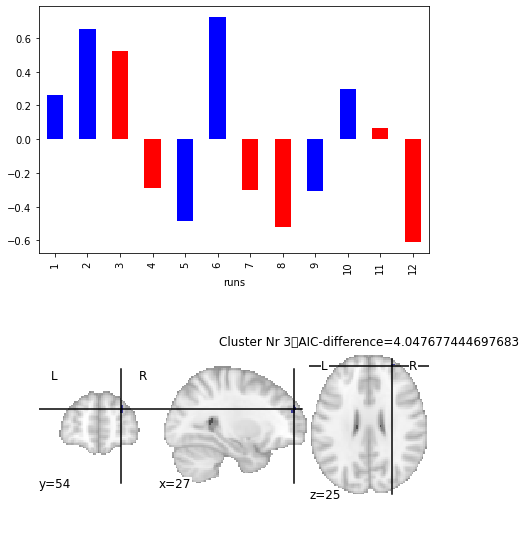

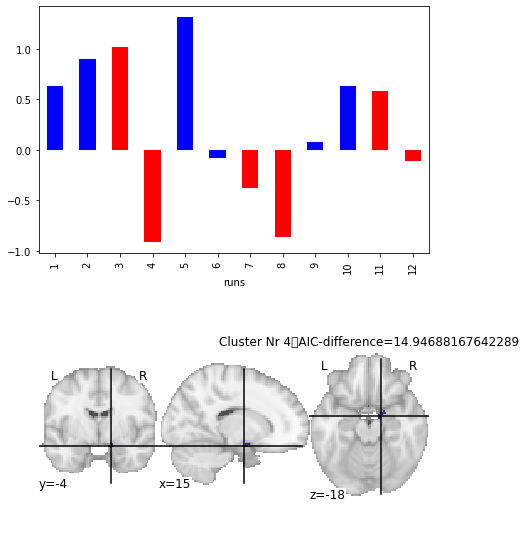

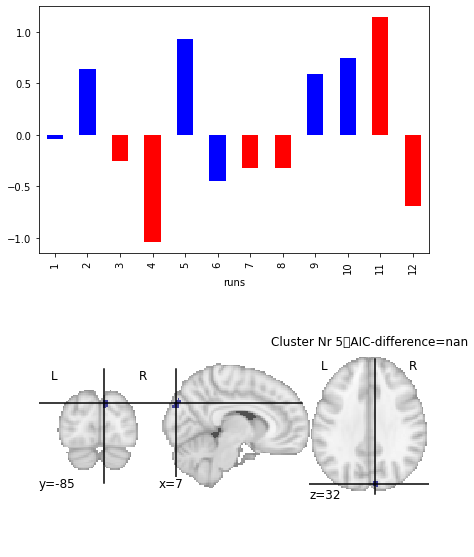

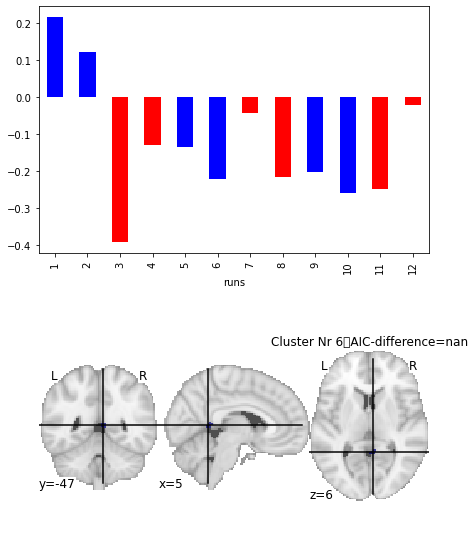

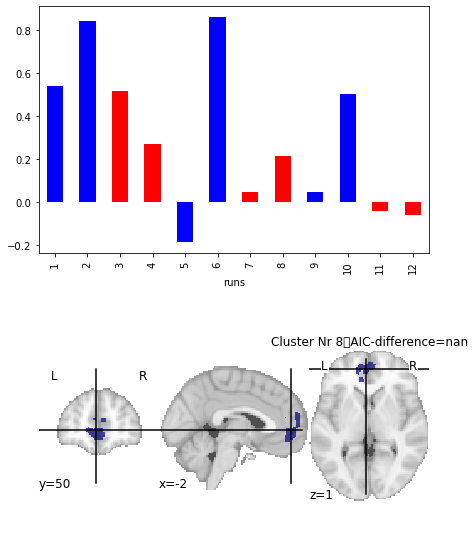

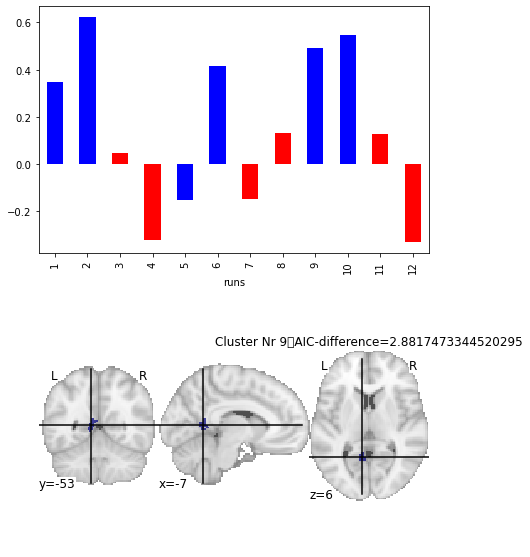

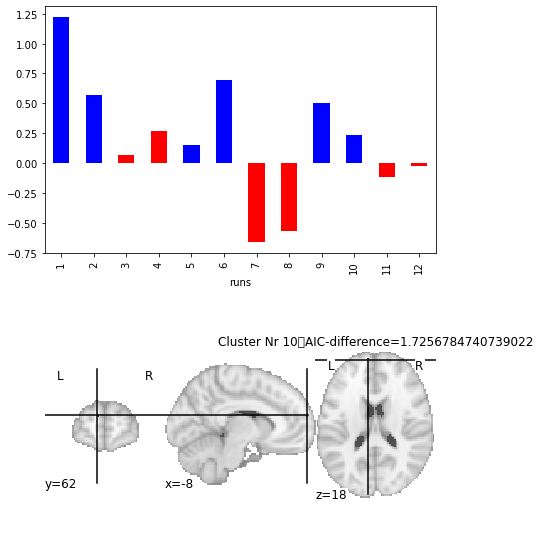

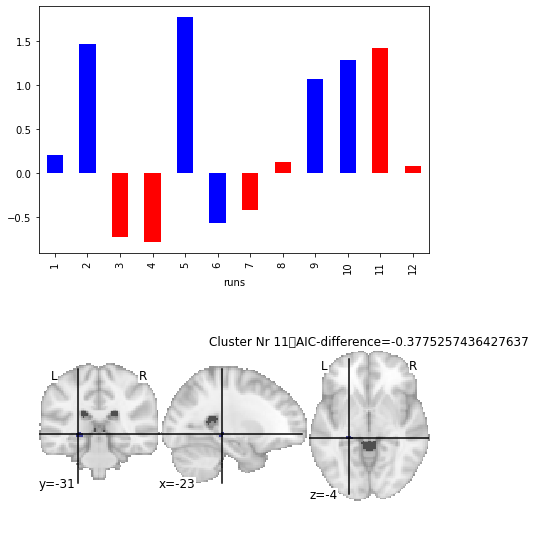

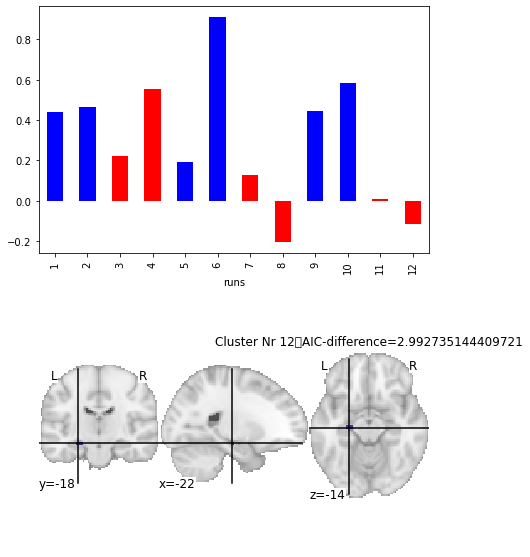

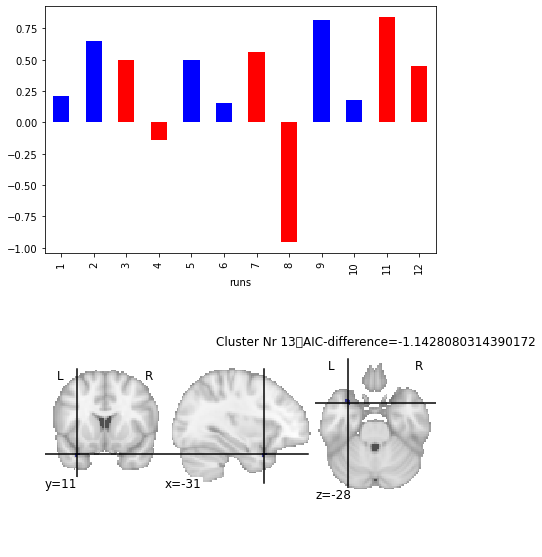

In [279]:
colors = ['b', 'b', 'r', 'r']*4
AIC_diffs = (np.min([AIC_df.runs_in_block, AIC_df.runs], axis=0) - AIC_df.pre_post)
for cl,diff in zip(AIC_df.cluster, AIC_diffs):
    # create figure to plot the cluster in and the corresponding bar-plot
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7, 10))
    # read in current cluster dataframe
    cluster_df = pd.read_csv(os.path.join(DATA_DIR, currentcontrast, 'cluster{:02}_df.csv'.format(cl)))
    cluster_df = cluster_df.pivot_table(index='subject', 
                                        columns='runs',
                                        values='betas',
                                        aggfunc='mean')
    cluster_df.mean().plot.bar(color=colors, ax=axes[0])
    
    current_roi = label_data==cl
    roi = new_img_like(ref_niimg=current_img, data=current_roi)
    plot = plotting.plot_roi(roi,axes=axes[1])
    
    plt.title('Cluster Nr {}\tAIC-difference={}'.format(cl,diff))

/gpfs01/bartels/user/vplikat/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


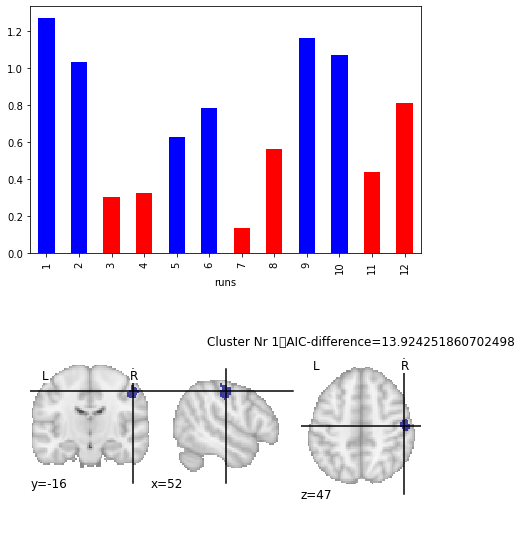

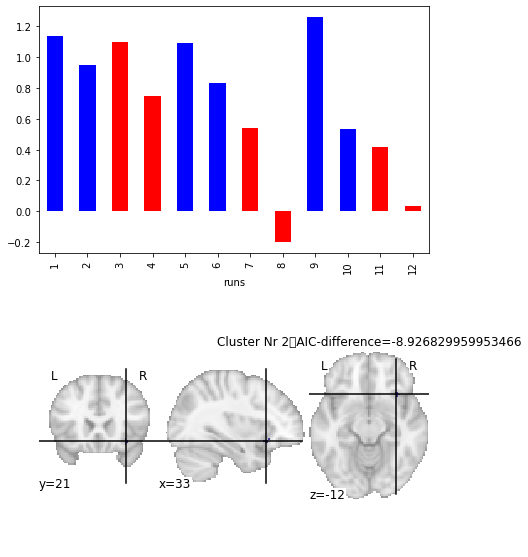

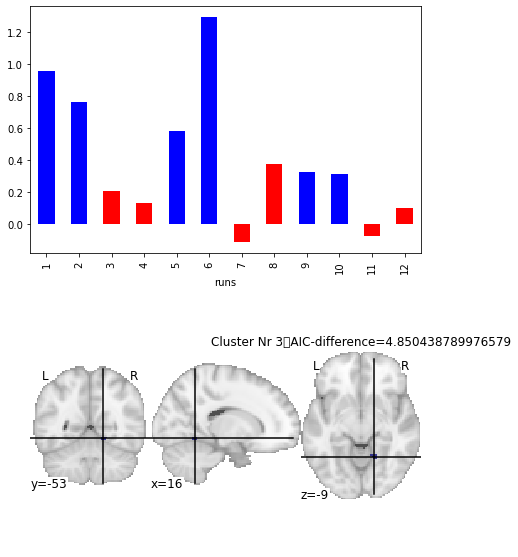

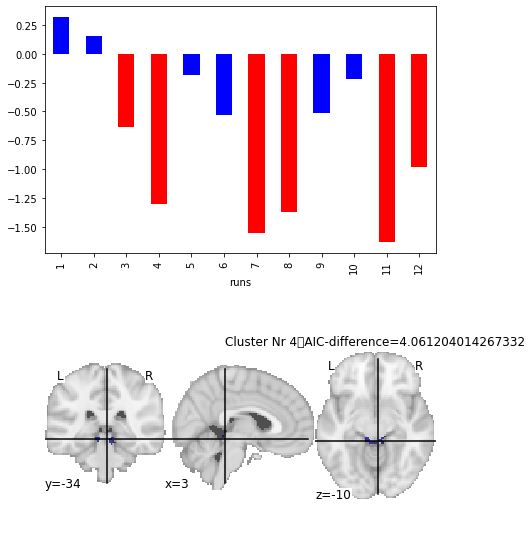

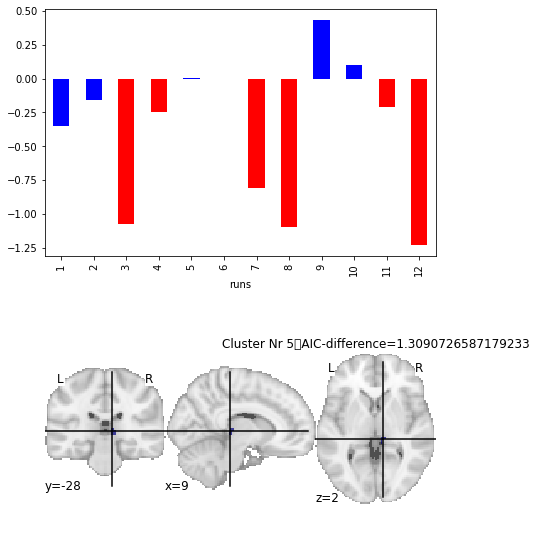

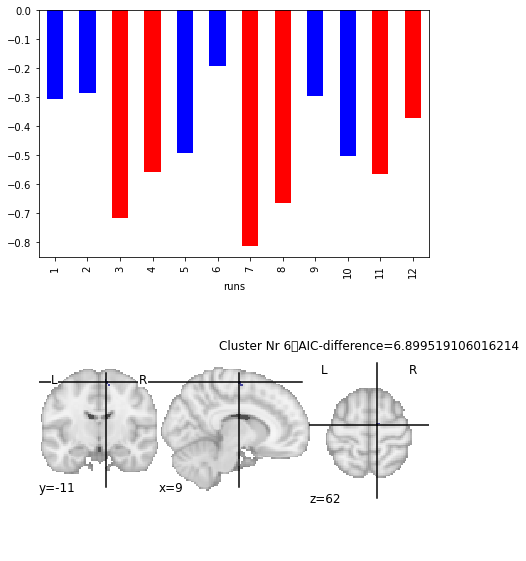

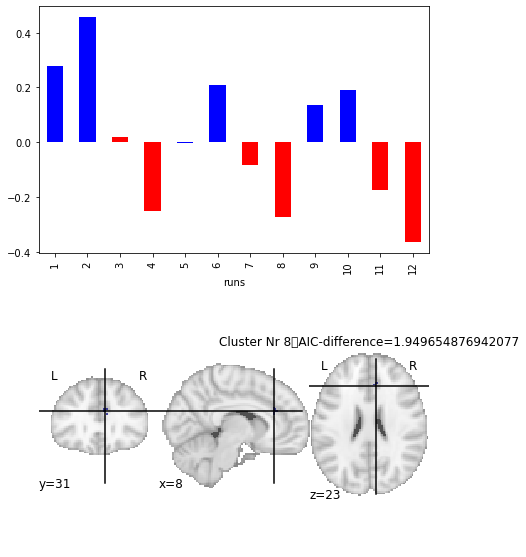

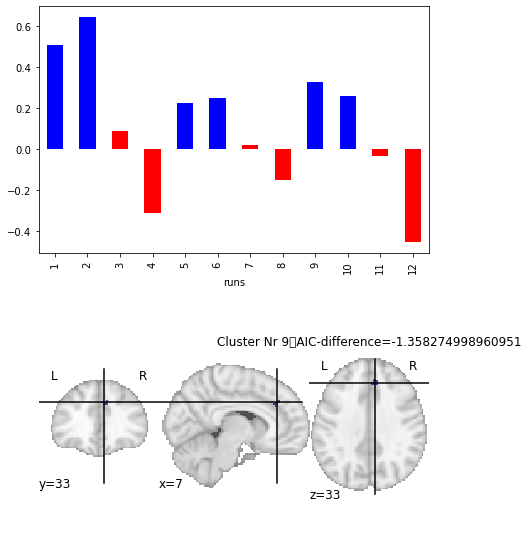

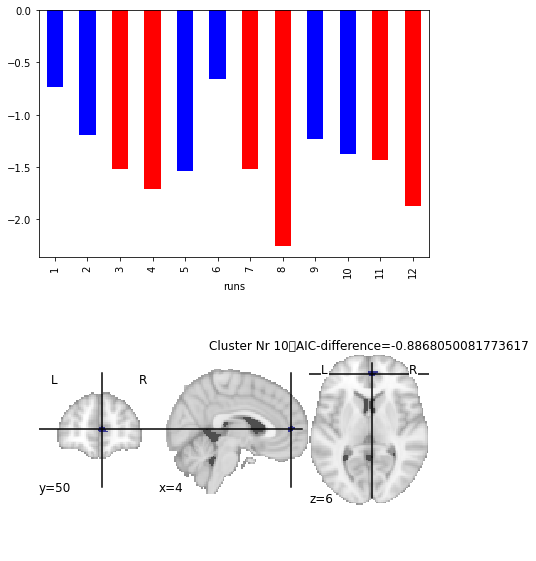

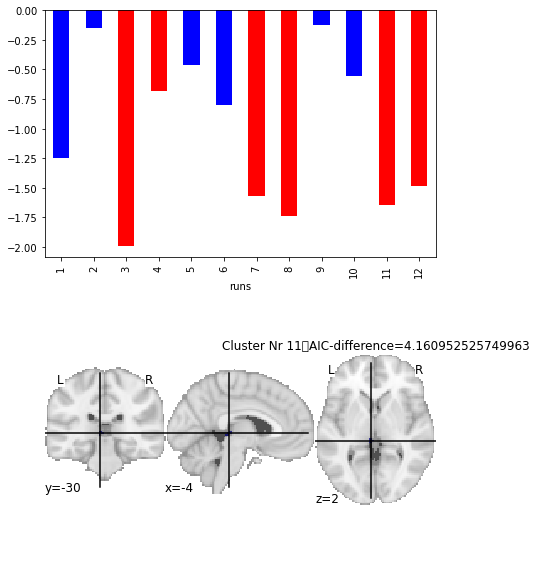

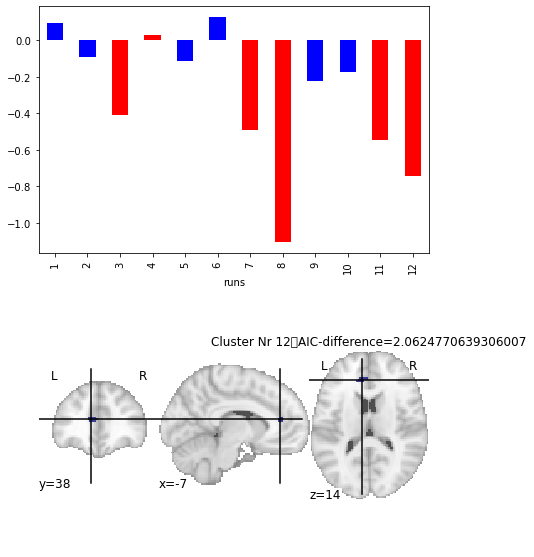

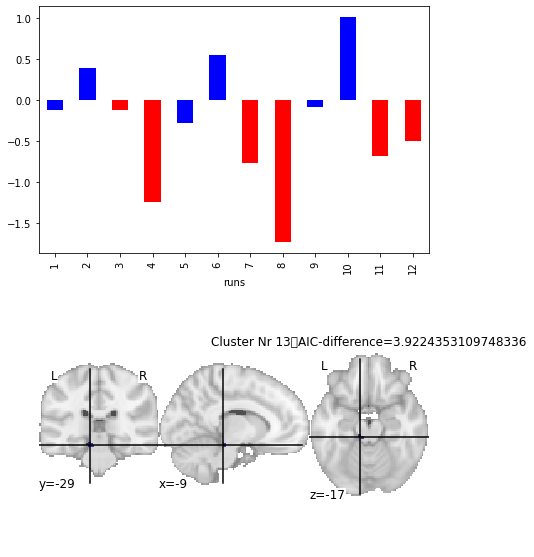

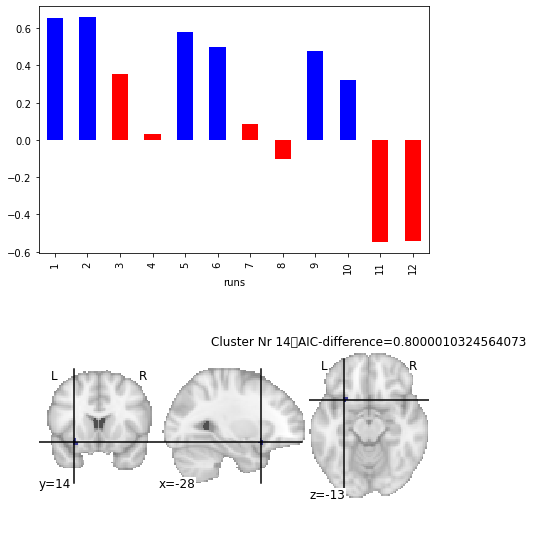

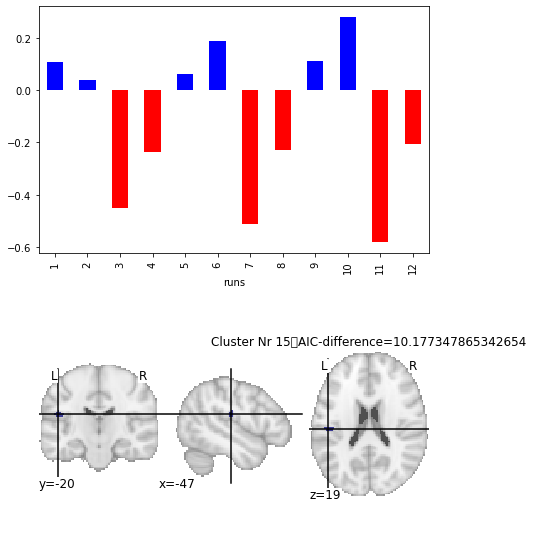

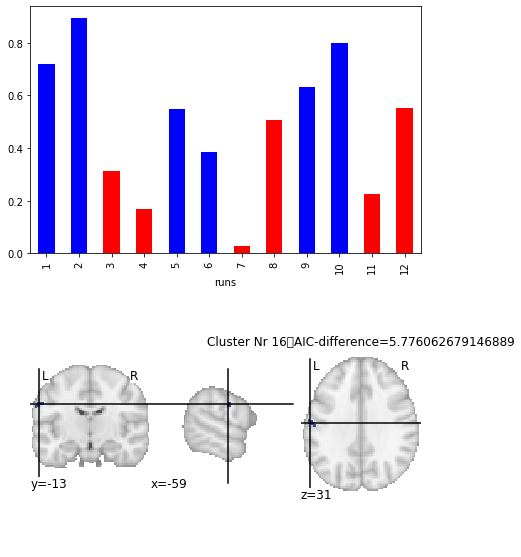

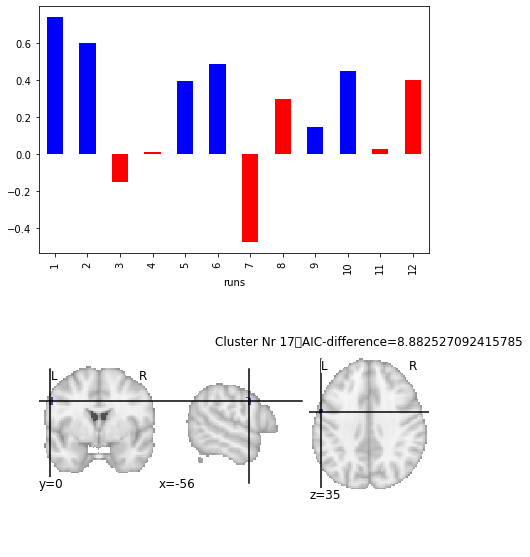

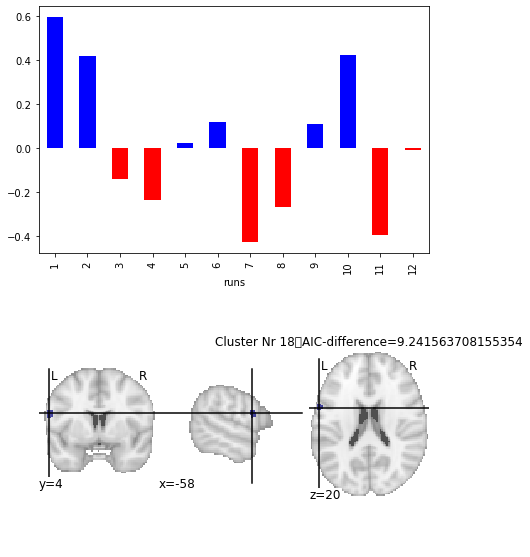

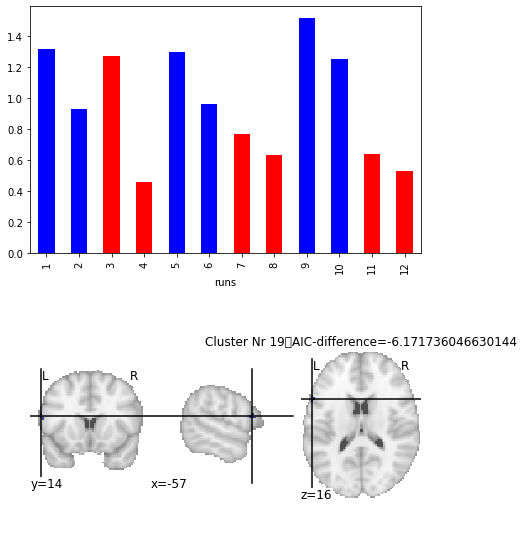

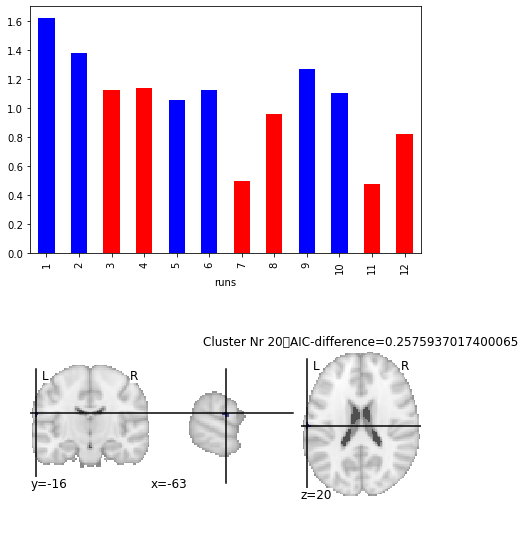

In [265]:
colors = ['b', 'b', 'r', 'r']*4
AIC_diffs = (np.min([AIC_df.runs_in_block, AIC_df.all_runs], axis=0) - AIC_df.pre_post)
for cl,diff in zip(AIC_df.index, AIC_diffs):
    # create figure to plot the cluster in and the corresponding bar-plot
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7, 10))
    # read in current cluster dataframe
    cluster_df = pd.read_csv(os.path.join(DATA_DIR, currentcontrast, 'cluster{:02}_df.csv'.format(cl)))
    cluster_df = cluster_df.pivot_table(index='subject', 
                                        columns='runs',
                                        values='betas',
                                        aggfunc='mean')
    cluster_df.mean().plot.bar(color=colors, ax=axes[0])
    
    current_roi = label_data==cl
    roi = new_img_like(ref_niimg=current_img, data=current_roi)
    plot = plotting.plot_roi(roi,axes=axes[1])
    
    plt.title('Cluster Nr {}\tAIC-difference={}'.format(cl,diff))

In [269]:
cluster_df

runs,1,2,3,4,5,6,7,8,9,10,11,12
subject,,,,,,,,,,,,
1,3.010000,2.910721,3.216415,0.413387,2.998036,2.045167,3.386026,2.961116,1.664060,1.169677,2.566591,0.451260
2,2.230715,0.624975,0.135203,-0.158375,-0.217259,0.846259,-0.335097,-0.399155,1.694946,1.552315,0.583194,1.205929
3,1.805938,1.183358,1.454651,1.358834,-0.524109,0.385193,-0.646801,0.931226,1.454576,-0.105067,-0.153692,1.087773
4,2.022294,1.962361,-0.486683,-0.125975,0.948194,1.108642,1.233666,0.682330,1.574208,2.182362,0.308857,1.916163
5,1.066132,1.629130,0.577855,0.089701,1.579679,2.211144,1.274068,0.620206,3.547124,2.905948,0.737414,2.733747
6,0.380147,0.123166,-0.235647,-0.062558,1.007601,2.664642,-0.326123,0.222113,0.182896,1.473802,-0.482625,0.835381
7,1.064137,0.865178,1.388163,0.683066,-0.406751,1.008448,-0.684932,-0.700404,0.138631,0.046380,0.531851,-0.544257
8,2.005772,0.953916,1.496153,0.573465,0.643090,1.405714,0.796874,1.328015,1.565685,2.035143,1.760422,1.583692
9,2.391947,0.916205,0.955967,-0.059172,0.890880,1.334386,-0.305948,1.107208,1.107795,2.457492,1.012662,1.295500
